Miscilanous plots of spectra.

In [2]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
import astropy.constants as const

from astropy.modeling import models, fitting

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

SDSS v X-shooter

In [3]:
sdss = fits.open('spectra/sdss/spec-4848-55955-0338.fits')

In [4]:
sdss.info()

Filename: spectra/sdss/spec-4848-55955-0338.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     126   ()      
  1                1 BinTableHDU     33   4641R x 8C   [E, E, E, J, J, E, E, E]   
  2                1 BinTableHDU    501   1R x 236C   [4A, 6A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 2A, D, D, 4A, 8A, E, E, E, J, E, 22A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 8A, 5A, E, E, E, E, E, E, E, E, J, E, E, J, J, 4A, 8A, E, 35E, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E

In [5]:
sdss[1].data.names

['FLUX', 'LOGLAM', 'IVAR', 'AND_MASK', 'OR_MASK', 'WDISP', 'SKY', 'MODEL']

In [6]:
data = sdss[1].data

/tmp/ipykernel_210166/2838300356.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(10**data['LOGLAM'], (1/data['IVAR'])**0.5)


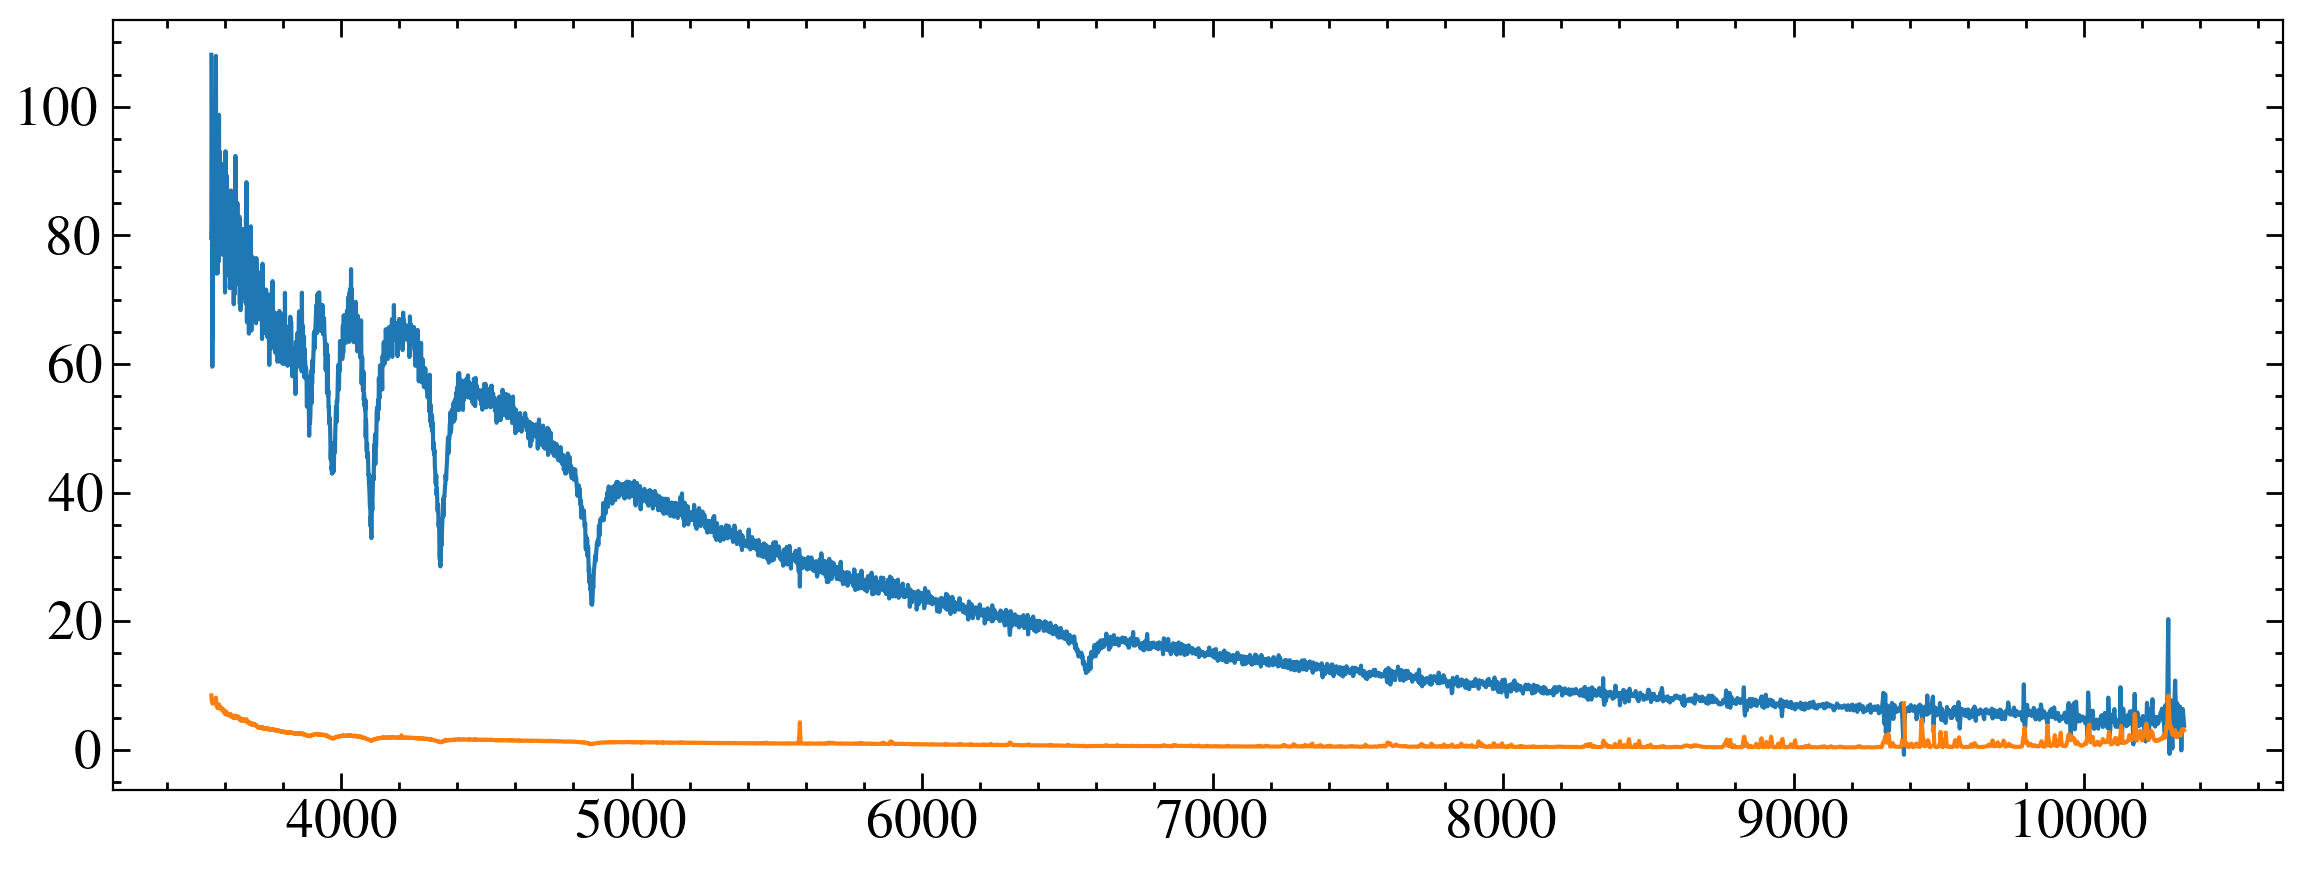

In [7]:
plt.plot(10**data['LOGLAM'], data['FLUX'])
plt.plot(10**data['LOGLAM'], (1/data['IVAR'])**0.5)


/tmp/ipykernel_210166/257297236.py:1: RuntimeWarning: divide by zero encountered in divide
  sw, sf, se = 10**data['LOGLAM'], data['FLUX']*1e-17, ((1/data['IVAR'])**0.5)*1e-17


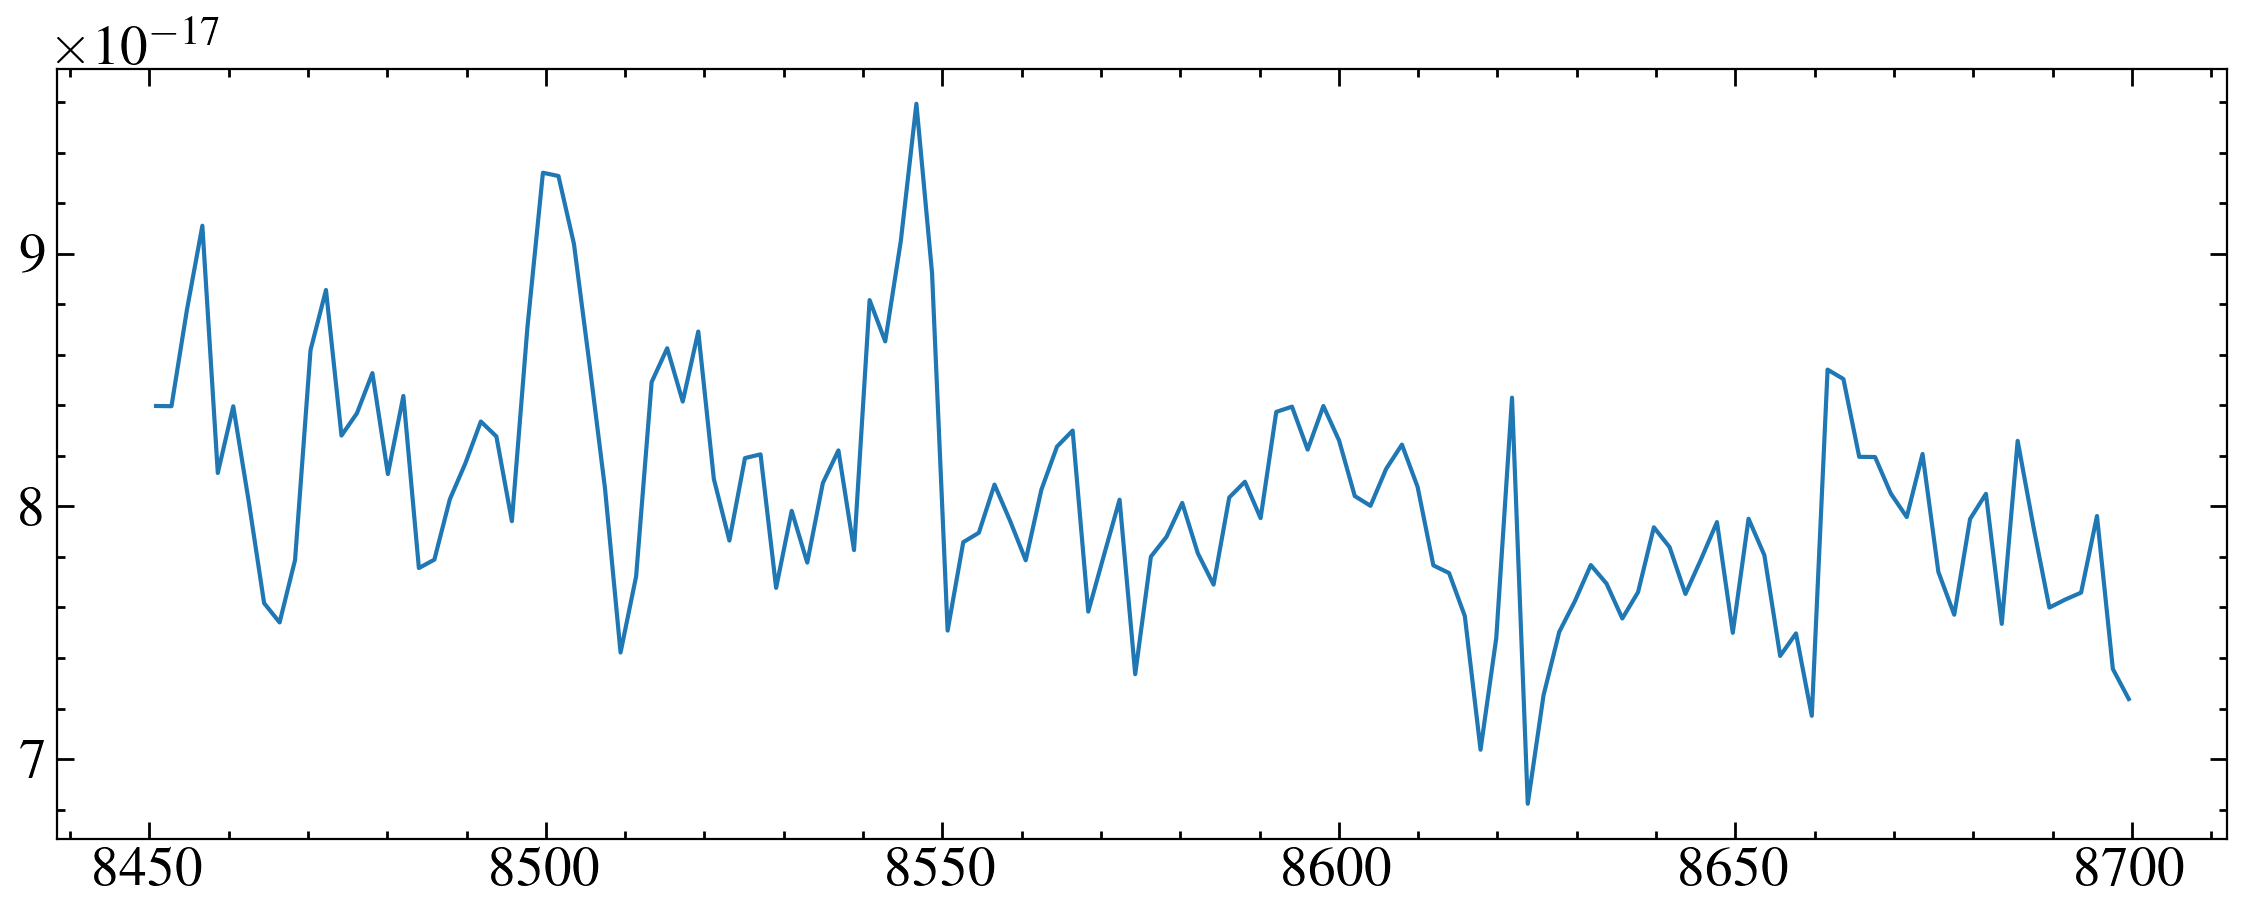

In [8]:
sw, sf, se = 10**data['LOGLAM'], data['FLUX']*1e-17, ((1/data['IVAR'])**0.5)*1e-17
mask = (sw > 8450) & (sw < 8700)
plt.plot(sw[mask], sf[mask])

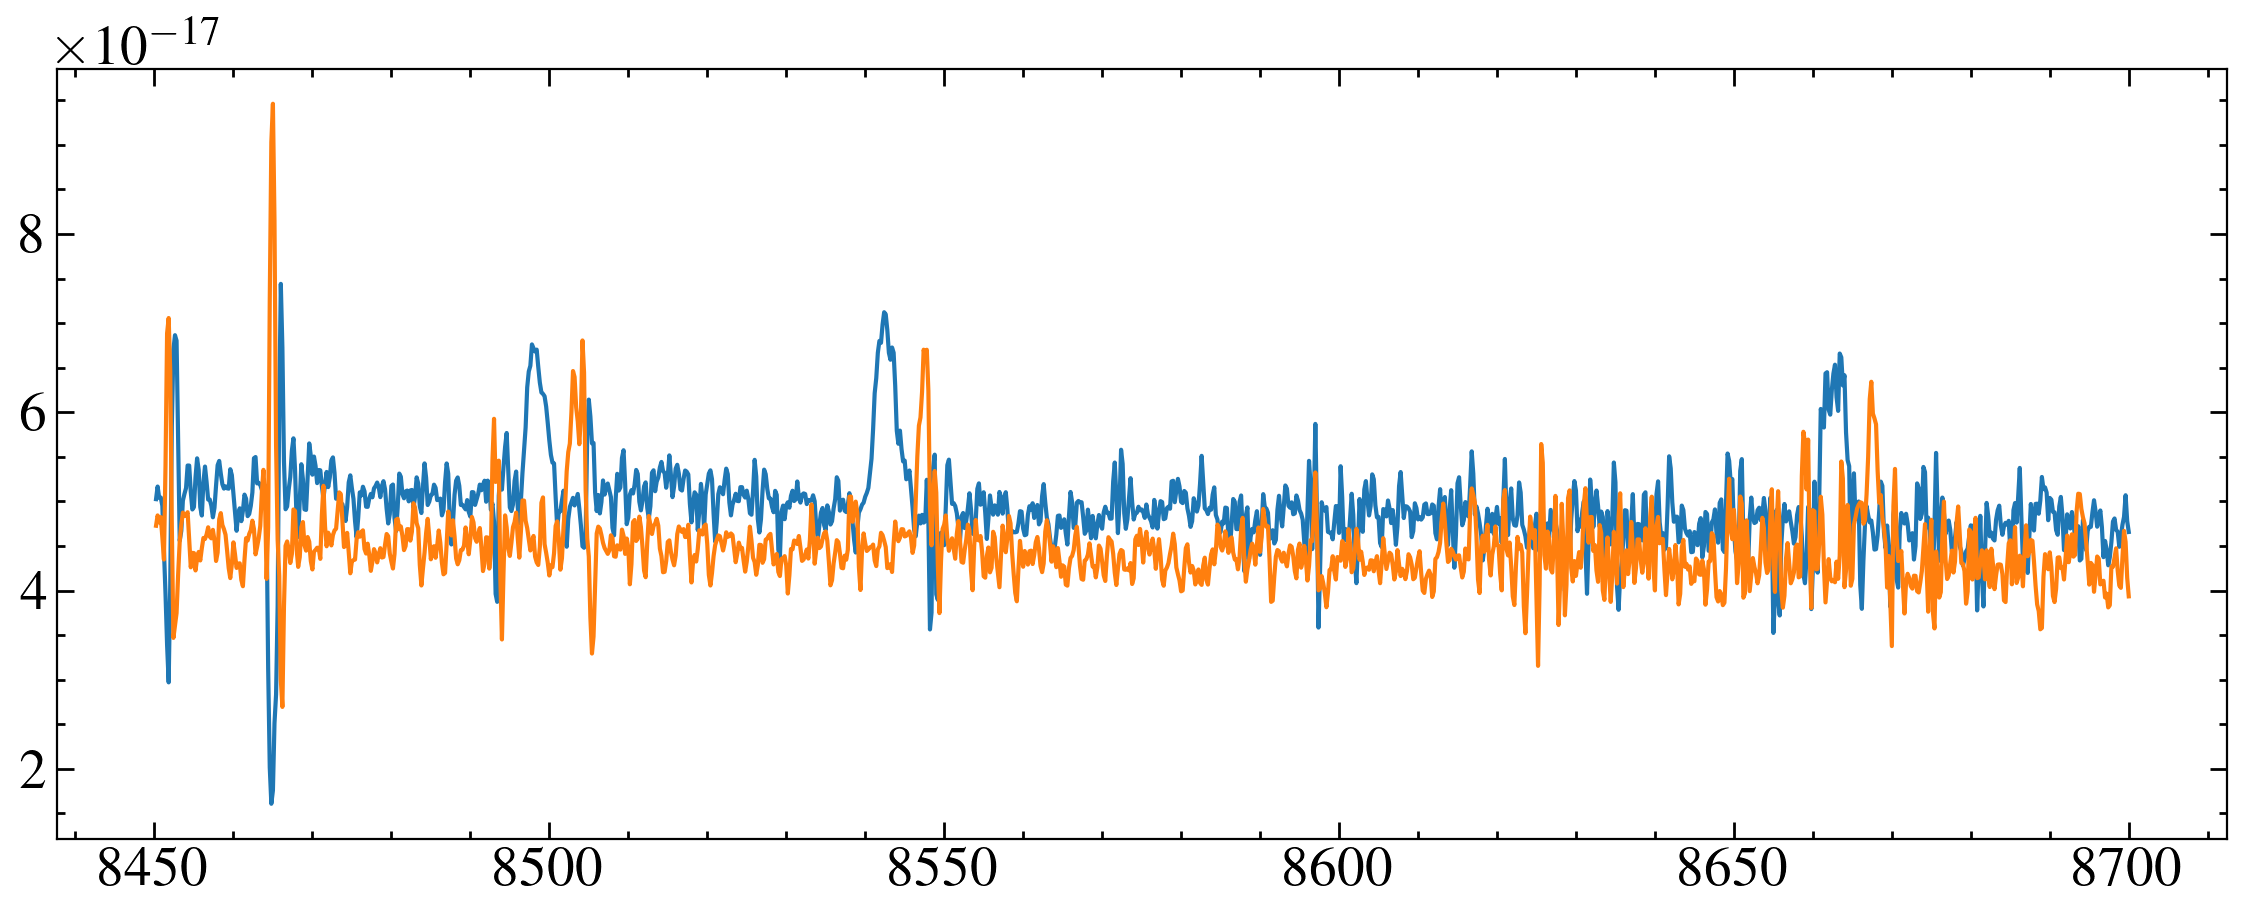

In [9]:
#xw, xf, xe = np.loadtxt('spectra/SDSSJ1144_old/SDSS1144_2_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv', unpack=True, delimiter=',')
xw, xf, xe = np.loadtxt('stare_extractions/SDSS1144_1_SCI_SLIT_FLUX_MERGE1D_VIS_58189.08029528.csv', unpack=True, delimiter=',')
mask = (xw > 8450) & (xw < 8700)
plt.plot(xw[mask], xf[mask])

xw1, xf1, xe1 = np.loadtxt('stare_extractions/SDSS1144_2_SCI_SLIT_FLUX_MERGE1D_VIS_58168.274911677.csv', unpack=True, delimiter=',')
mask = (xw1 > 8450) & (xw1 < 8700)
plt.plot(xw1[mask], xf1[mask])

<>:45: SyntaxWarning: invalid escape sequence '\A'
<>:45: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_210166/768258990.py:45: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Wavelength (\AA)')


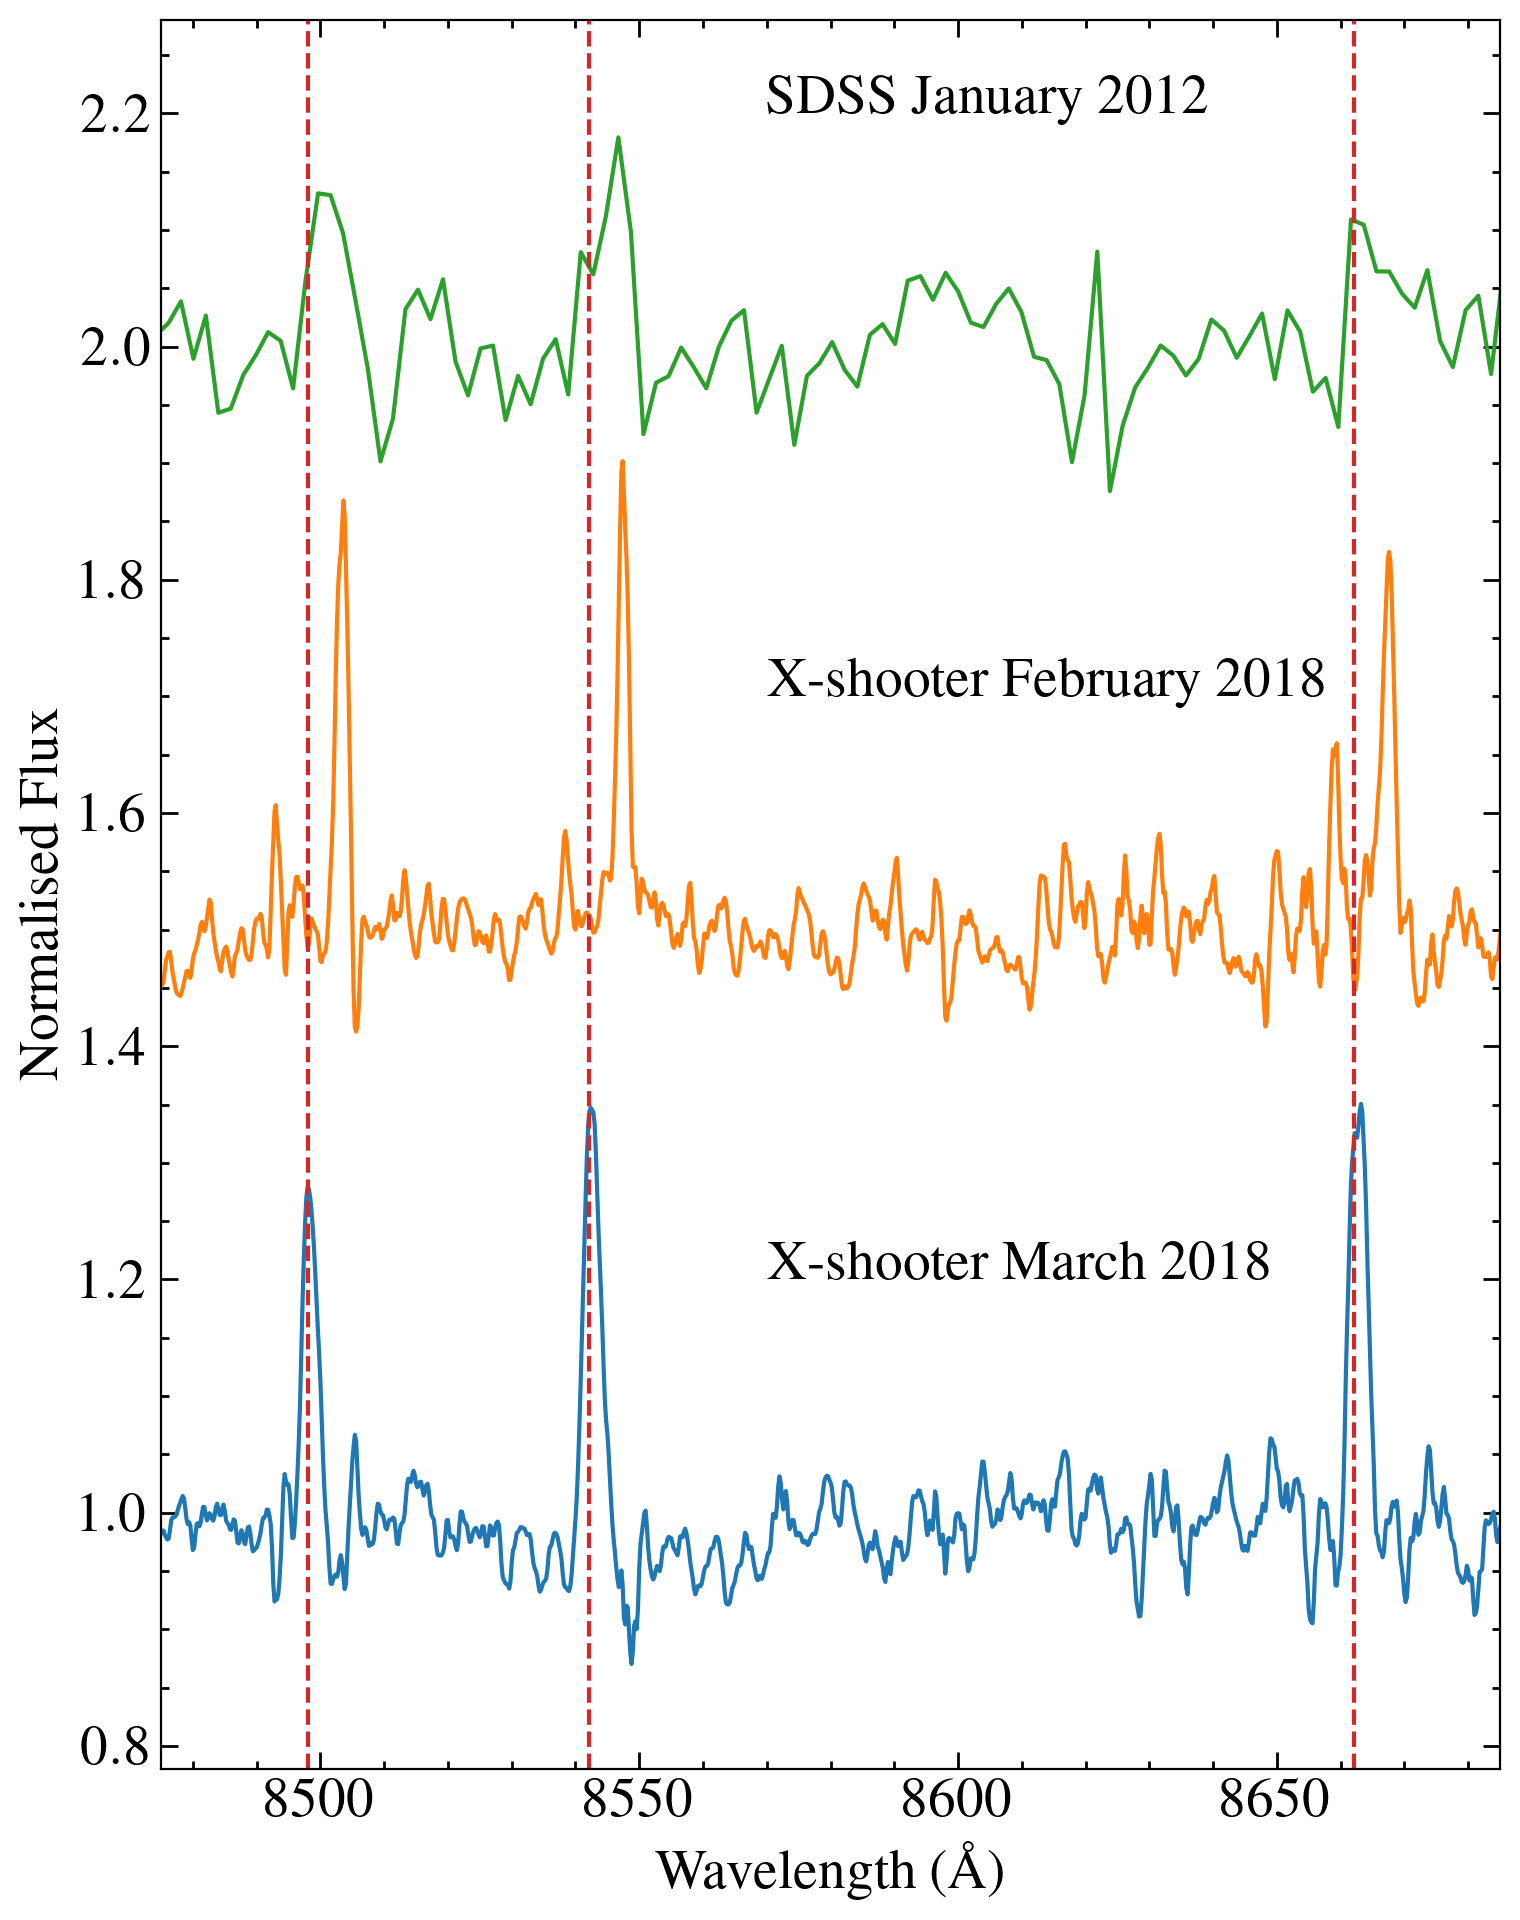

In [10]:
fitter = fitting.LevMarLSQFitter()


def get_shifted_lines(x, lines):
    #calculates the approximate positions of the shifted lines
    rest_lam = lines[0]*u.AA
    obs_lam = x*u.AA
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
    #print(dv)
    l2 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[1]*u.AA))
    l3 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[2]*u.AA))
    return np.array([x, l2.value, l3.value])


def make_plot_spec(w, f, e, mask1, mask2,smooth=10): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    if smooth > 0:
        nf = convolve(nf,Box1DKernel(smooth))
        ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne

lines = [8498.02,8542.09,8662.14]

#smask = (sw > 8450) & (sw < 8700)
#plt.plot(sw[smask], sf[smask])

#xmask = (xw > 8450) & (xw < 8700)
#plt.plot(xw[xmask], xf[xmask])
plt.figure(figsize=(8,10))
for i, w, f, e, smooth in zip([0,1, 2],[xw, xw1, sw], [xf, xf1, sf], [xe, xe1, se], [8, 8, 0]):
    slines = get_shifted_lines(8505, lines)
    mask1 = (w > 8460) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8470) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=smooth)
    #plt.step(w[2:-2],f[2:-2]+i*0.5, label = label, where='mid')
    plt.plot(w[2:-2],f[2:-2]+i*0.5)
#plt.legend()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalised Flux')
[plt.axvline(line, ls='--', c='C3') for line in lines]
plt.xlim(8475, 8685)
plt.ylim(0.78, 2.28)
plt.annotate('X-shooter March 2018', (8570, 1.2), xycoords='data')
plt.annotate('SDSS January 2012', (8570, 2.2), xycoords='data')
plt.annotate('X-shooter February 2018', (8570, 1.7), xycoords='data')

plt.tight_layout()
plt.savefig('plots/sdss_v_xshooter.pdf')


In [11]:
sdss[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   32 /Number of bytes per row                         
NAXIS2  =                 4641 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    8 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [12]:
# visfits = glob.glob('spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/*VIS*fits')
# print(len(visfits))
# for v in visfits:
#     print(fits.getheader(v)['EXPTIME'])

In [13]:
phot = Table.read('1144_phot.txt', format='ascii.basic')
phot

band,nu(GHz),fnu(Jy),fnu_e(Jy)
str3,float64,float64,float64
fuv,1960700.0,0.000912,2.5e-05
nuv,1296700.0,0.000655,1.8e-05
u,851920.0,0.000446,2.9e-05
g,621980.0,0.000438,4e-06
r,479900.0,0.000312,9e-06
i,392660.0,0.000238,7e-06
z,332440.0,0.000179,1e-05
J,240160.0,0.000117,3e-06
H,183780.0,7.76e-05,7.6e-06


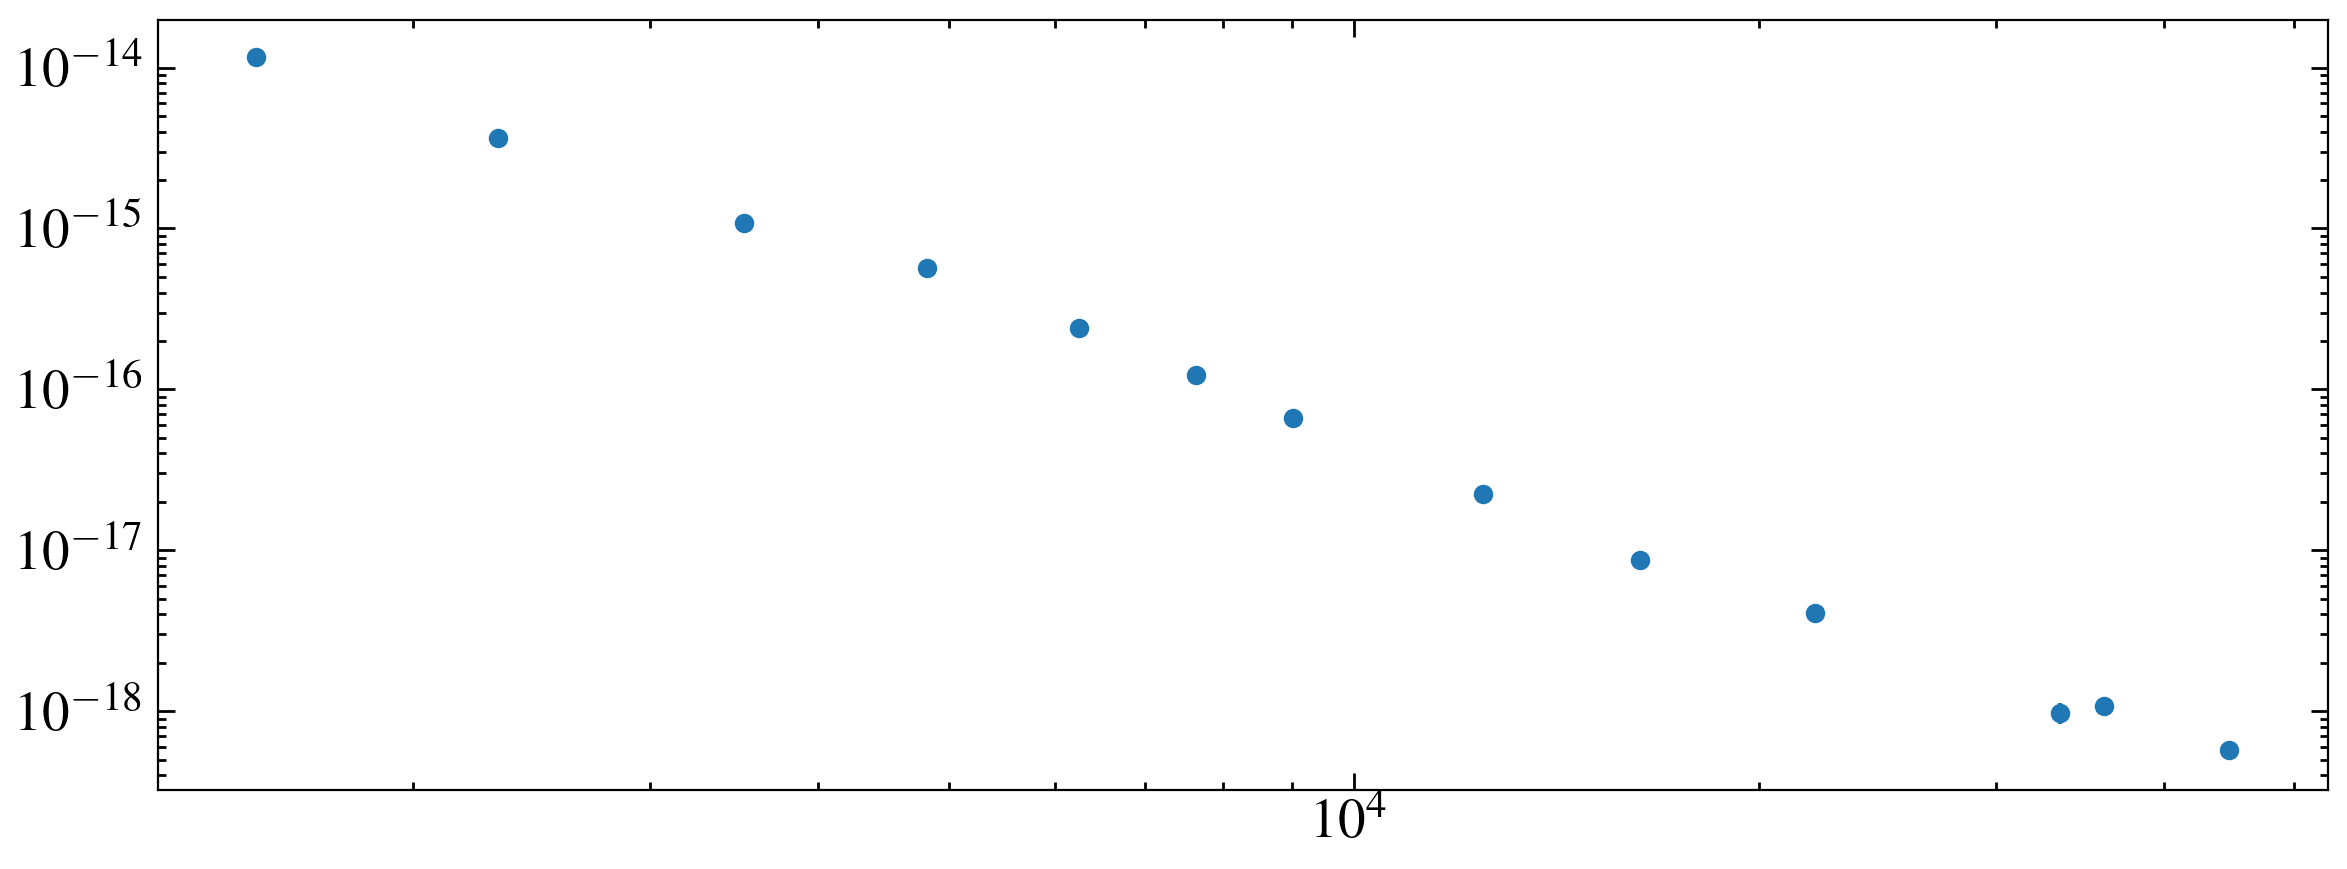

In [14]:
fig, ax = plt.subplots()

photw = (phot['nu(GHz)']*u.GHz).to(u.AA, equivalencies=u.spectral())
photf = (phot['fnu(Jy)']*u.Jy).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(photw))
phote = phot['fnu_e(Jy)']/phot['fnu(Jy)'] * photf

ax.errorbar(photw, photf, yerr=phote, marker='o', ls='none')

ax.set_yscale('log')
ax.set_xscale('log')

In [15]:
from dust_extinction.parameter_averages import F99
ext = F99(Rv=3.1)


In [16]:
teff, teffe = 20295.58, 1609.44
logg, logge = 7.706178, 0.121429
M1, M1e =  0.475735, 0.045966
dist, diste = 264.25576800, np.mean([264.25576800-256.65420500,271.86544800-264.25576800])
AV = 0.050
rwd = 0.0160

wdpath = '/media/david/2tb_ext_hd/hddata/dk_wds/'
wd_mod = 'da20000_775.dk.dat.txt'

mw, mf = np.loadtxt(wdpath+wd_mod, unpack=True)

mask = mw > 1000 
mw, mf = mw[mask], mf[mask]

fig, ax = plt.subplots()

scale = (rwd*u.Rsun/ (dist*u.pc).to(u.Rsun))**2
redopt = ext.extinguish(mw*u.AA, Av=AV) 

ax.plot(mw, mf*scale/redopt)



ax.errorbar(photw, photf, yerr=phote, marker='o', ls='none')

ax.set_yscale('log')
ax.set_xscale('log')

FileNotFoundError: /media/david/2tb_ext_hd/hddata/dk_wds/da20000_775.dk.dat.txt not found.

In [17]:
import pandas as pd
from itertools import islice
def load_pier_da_model(files, dir_mod):
    """From Sneha, modified by me"""

    with open(dir_mod+files[0]) as lines: #dir_mod = folder where models are stored

        wn = np.ndarray.flatten(np.genfromtxt(islice(lines, 1, 270)))
        # print(array)
    teff_mod= np.hstack((np.arange(1500., 5500., 250.), 
                         np.arange(5500., 17001., 500.), 
                         np.arange(20000., 90000., 5000.), 
                         np.arange(90000., 140001., 10000.)))
    fn=[]
    gn=[]
    tn=[]
    for i in range(10,46):
        for j in range(len(files)):
            with open(dir_mod+files[j]) as lines:
                array1 = np.genfromtxt(islice(lines, 274+453*i, 274+453*i+448))
                gn.append(float('{0:.3g}'.format(int(files[j][:-7])/100)))
                tn.append(teff_mod[i])
                fn.append(array1.flatten())
    wn=wn[:2688]*u.AA
    fn=fn*u.erg / u.cm**2 / u.s / u.Hz
    fn=fn.to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(wn))
    return wn, fn, tn, gn

In [18]:
wdpath = '/media/david/2tb_ext_hd/hddata/pet_wdmodels/da_1d_nlte/grid_IR/'
modfile = '750_LyA_IR'

In [19]:
wn, fn, tn, gn = load_pier_da_model([modfile], wdpath)

FileNotFoundError: [Errno 2] No such file or directory: '/media/david/2tb_ext_hd/hddata/pet_wdmodels/da_1d_nlte/grid_IR/750_LyA_IR'

In [ ]:
np.where((np.array(tn) == 20000.0))[0][0]

In [ ]:




teff, teffe = 20295.58, 1609.44
logg, logge = 7.706178, 0.121429
M1, M1e =  0.475735, 0.045966
dist, diste = 264.25576800, np.mean([264.25576800-256.65420500,271.86544800-264.25576800])
AV = 0.050
rwd = 0.0160

mf = fn[30]
mw = wn.value
mask = (mw > 1100) & (mw< 60000) 
mw, mf = mw[mask], mf[mask]

fig, ax = plt.subplots()

#extincion is negligable

# scale = 4*np.pi*(rwd*u.Rsun/ (dist*u.pc).to(u.Rsun))**2
# redopt = ext.extinguish(mw*u.AA, Av=AV) 

# ax.plot(mw, mf*scale/redopt)
ax.plot(mw, mf*scale)



ax.errorbar(photw, photf, yerr=phote, marker='o', ls='none')

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
# import prepare_phoenix_svo as pp


# G = const.G
# M = const.M_sun.to(u.kg)
# R = const.R_sun.to(u.m)

# mass = 0.074
# teff = 2290
# teff_e = 200
# radius = 0.085
# distance = dist
# save_path = 'phx/'
# star = 'wd1144b'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
# g = np.log10(g.value)
# print(g)
# # print(np.log10(g.value))
# # g = 4.623
# repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

# star_params = {'Teff': teff, 'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc, 'Teff_e':teff_e}
# pw, pf = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=False, make_error=False)
# normfac = ((radius*R)/(distance*u.pc.to(u.m)))**2
# pdata = Table.read('phx/wd1144b_phoenix_interpolated.ecsv')
# pw, pf =  pdata['WAVELENGTH'], pdata['FLUX'] 

In [ ]:
# def make_filepath(Teff, logg=4.5, repo='ftp'):
#     """
#     Constructs the filepath for a phoenix spectrum file for a star with effective
#     temperature Teff, log surface gravity logg. 
#     """
   
#     name = 'lte{T:05.1f}-{g:3.1f}-0.0a+0.0.BT-Settl.spec.7.dat'.format(T=Teff/100.0, g=logg)
#     return name

# make_filepath(2200, logg=5.)

cascade plot of the spectra, folded.

In [ ]:
def make_plot_spec(w, f, e, mask1, mask2, smooth=10): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    # smooth = 10
    if smooth > 0:
        nf = convolve(nf,Box1DKernel(smooth))
        ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne
    

In [ ]:
fitter = fitting.LevMarLSQFitter()
# dvs = Table.read('dv_lists/bd_dvs.ecsv')
# dvs = dvs[4:]
# mjds = dvs

fit_period = 4.223067122780375

path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

vispath = path + 'VIS_notell/'
sp = glob.glob(vispath+'*TAC.csv')

dates = []

for s in sp:
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS'] +  (fits.getheader(s[:-3]+'fits')['EXPTIME'])/(2*86400)
    dates.append(date)

phases = np.array(dates)/(fit_period/24) % 1

phase_args = np.argsort(phases)

phase_sort = phases[phase_args]
specs_sort = np.array(sp)[phase_args]
lines = [8498.02,8542.09,8662.14]


fig, ax = plt.subplots(figsize=(6, 20))

skip = 3
for i, spec in enumerate(specs_sort[::skip]):
    w, f, e = np.loadtxt(spec, unpack=True, delimiter=',')
    slines = lines
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=10)

    ax.plot(w,(f-1)+phase_sort[::skip][i], alpha=0.5, c= plt.cm.plasma(phase_sort[::skip][i]))
   
ax.set_xlim(8470, 8570)
# ax.set_xlim(lines[1]-10, lines[1]+10)
ax.set_ylim(-0.01, 1.51)

Ok that didn't work

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

skip =2

for i, spec in enumerate(specs_sort[::skip]):
    w, f, e = np.loadtxt(spec, unpack=True, delimiter=',')
    slines = lines
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=10)
    mask = (w> 8470) & (w < 8570)
    w, f = w[mask], f[mask]

    ax.plot(w,phase_sort[::skip][i], zs=f, alpha=0.7, c= plt.cm.plasma(phase_sort[::skip][i]), zdir='z')

ax.set_xlim(8480, 8570)
ax.set_zlim(0.9, 1.5)


urgh has to be 2d

In [ ]:
# fitter = fitting.LevMarLSQFitter()
# dvs = Table.read('dv_lists/bd_dvs.ecsv')
# dvs = dvs[4:]
# mjds = dvs

fit_period = 4.223067122780375

path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

vispath = path + 'VIS_notell/'
sp = glob.glob(vispath+'*TAC.csv')

dates = []

for s in sp:
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS'] +  (fits.getheader(s[:-3]+'fits')['EXPTIME'])/(2*86400)
    dates.append(date)

phases = np.array(dates)/(fit_period/24) % 1

phase_args = np.argsort(phases)

phase_sort = phases[phase_args]
specs_sort = np.array(sp)[phase_args]
lines = [8498.02,8542.09,8662.14]


fig, ax = plt.subplots(figsize=(10, 6))

skip = 1
# for i, spec in enumerate(specs_sort[::skip]):
for i, spec in enumerate(specs_sort):
    w, f, e = np.loadtxt(spec, unpack=True, delimiter=',')
    slines = lines
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=10)

    # ax.plot(w,f, alpha=0.5, c= plt.cm.plasma(phase_sort[::skip][i]))
    ax.plot(w,f, alpha=0.1, c= plt.cm.plasma(0.1))
   
# ax.set_xlim(8470, 8570)
# ax.set_xlim(lines[1]-10, lines[1]+10)
# ax.set_ylim(-0.01, 1.51)
ax.set_ylim(0.81, 1.61)

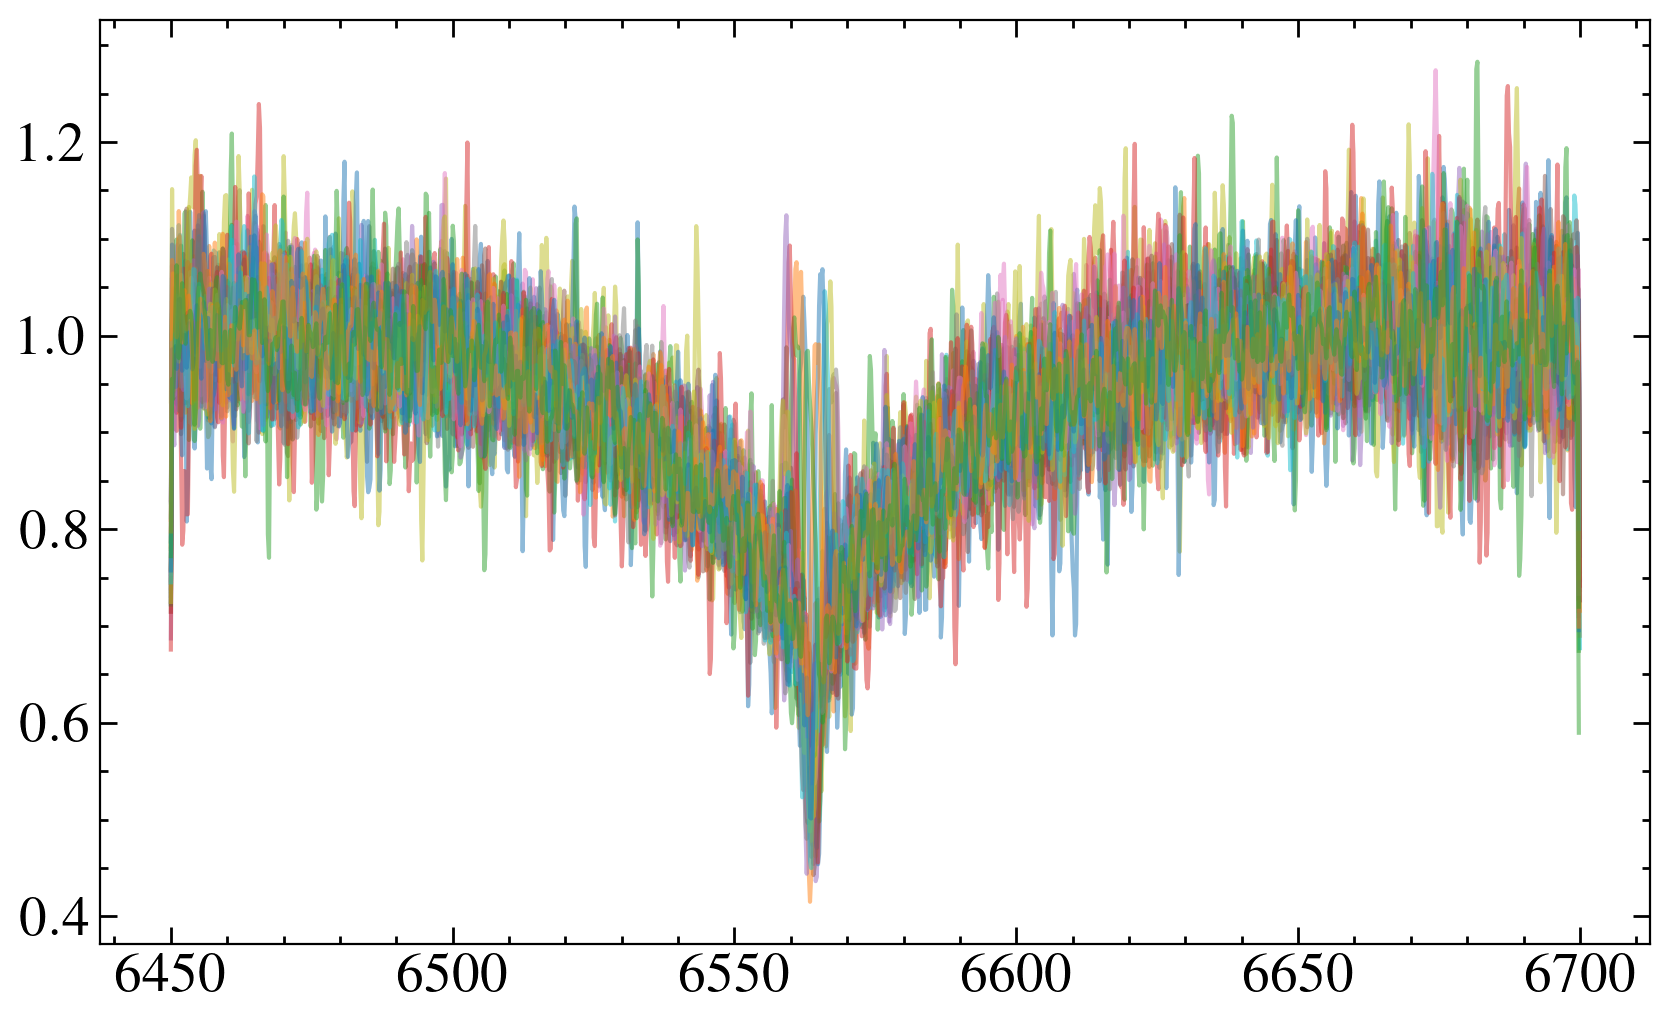

In [20]:
# fitter = fitting.LevMarLSQFitter()
# dvs = Table.read('dv_lists/bd_dvs.ecsv')
# dvs = dvs[4:]
# mjds = dvs

fit_period = 4.223067122780375
eph = 58601.212968249274

path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

vispath = path + 'VIS_notell/'
sp = glob.glob(vispath+'*TAC.csv')


uvbpath = path + 'UVB/'
uvbsp = glob.glob(uvbpath+'*.csv')


dates = []

for s in sp:
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS'] +  (fits.getheader(s[:-3]+'fits')['EXPTIME'])/(2*86400)
    dates.append(date)

phases = (np.array(dates)-eph)/(fit_period/24) % 1

phase_args = np.argsort(phases)

phase_sort = phases[phase_args]
specs_sort = np.array(sp)[phase_args]
# uvb_sort = np.array(uvbsp)[phase_args]
# lines = [8498.02,8542.09,8662.14]

gamma = 28.1*u.km/u.s

fluxes = []
ha_fluxes = []


fig, ax = plt.subplots(figsize=(10, 6))

# for i, spec in enumerate(specs_sort[::skip]):
for i, spec in enumerate(specs_sort):
    w, f, e = np.loadtxt(spec, unpack=True, delimiter=',')
    slines = lines
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=2)
    v = (w*u.AA).to(u.km/u.s, equivalencies=u.doppler_optical(lines[1]*u.AA))

    # ax.plot(w,f, alpha=0.5, c= plt.cm.plasma(phase_sort[::skip][i]))
    # ax.plot(v-gamma,f, alpha=0.3, c= plt.cm.plasma(i/len(specs_sort)))
    if i == 0:
        w_c2 = w
    else:
        f = np.interp(w_c2, w, f)
    fluxes.append(f)
    # w_c2 = w
    # w_uv, f, e = np.loadtxt(uvb_sort[i], unpack=True, delimiter=' ')
    w, f, e = np.loadtxt(spec, unpack=True, delimiter=',')
    mask1 = (w > 6400) & (w < 6500) | (w > 6650) & (w < 6700)
    mask2 = (w > 6450) & (w < 6700)
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=2)
    
    ax.plot(w, f, alpha=0.5)
    if i == 0:
        w_ha = w
    else:
        f = np.interp(w_ha, w, f)
    ha_fluxes.append(f)
    # w_ha = w
    

    
    # print(len(f))
   
# ax.set_xlim(8470, 8570)
# ax.set_xlim(lines[1]-10, lines[1]+10)
# ax.set_ylim(-0.01, 1.51)
# ax.set_ylim(0.81, 1.61)

# ax.set_xlim(-500, 500)

fluxes= np.array(fluxes)
ha_fluxes= np.array(ha_fluxes)


Text(0, 0.5, 'Phase')

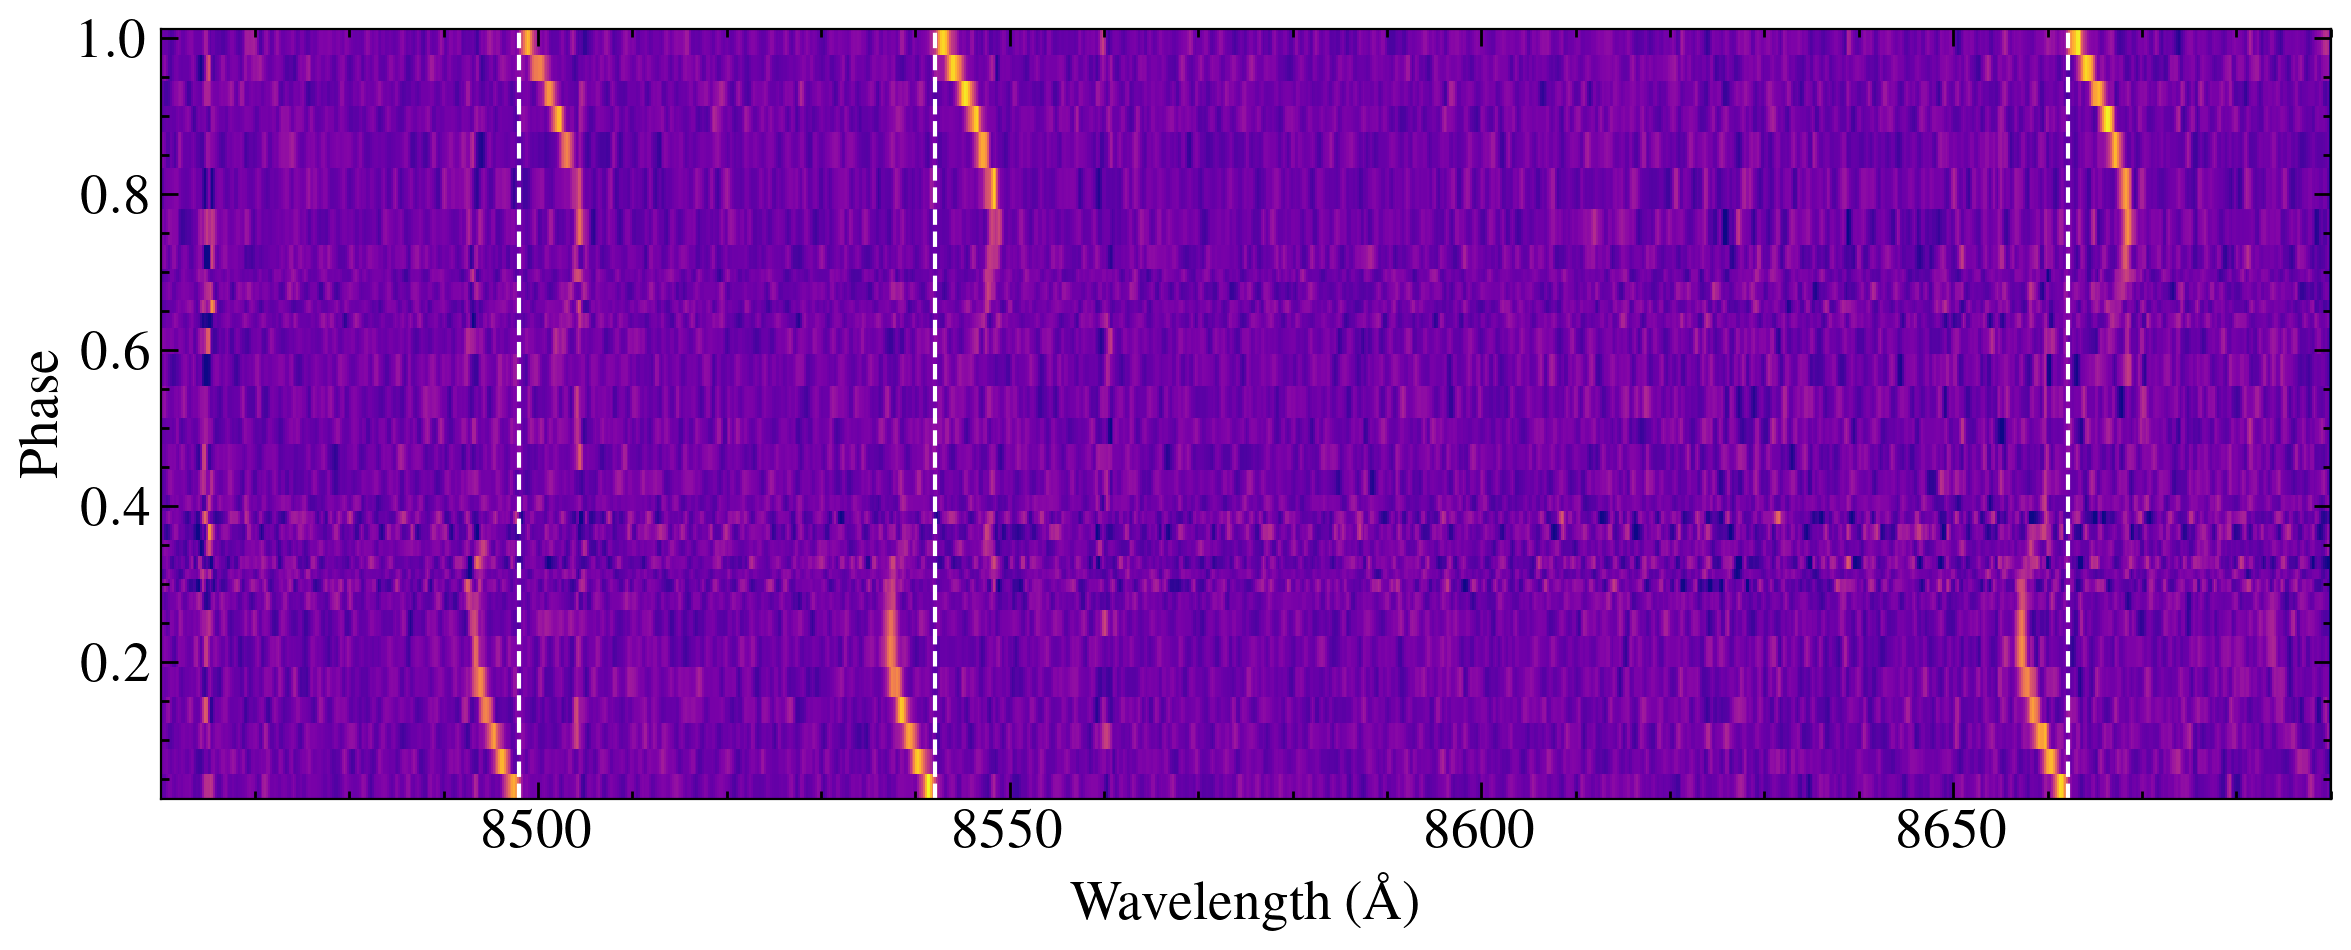

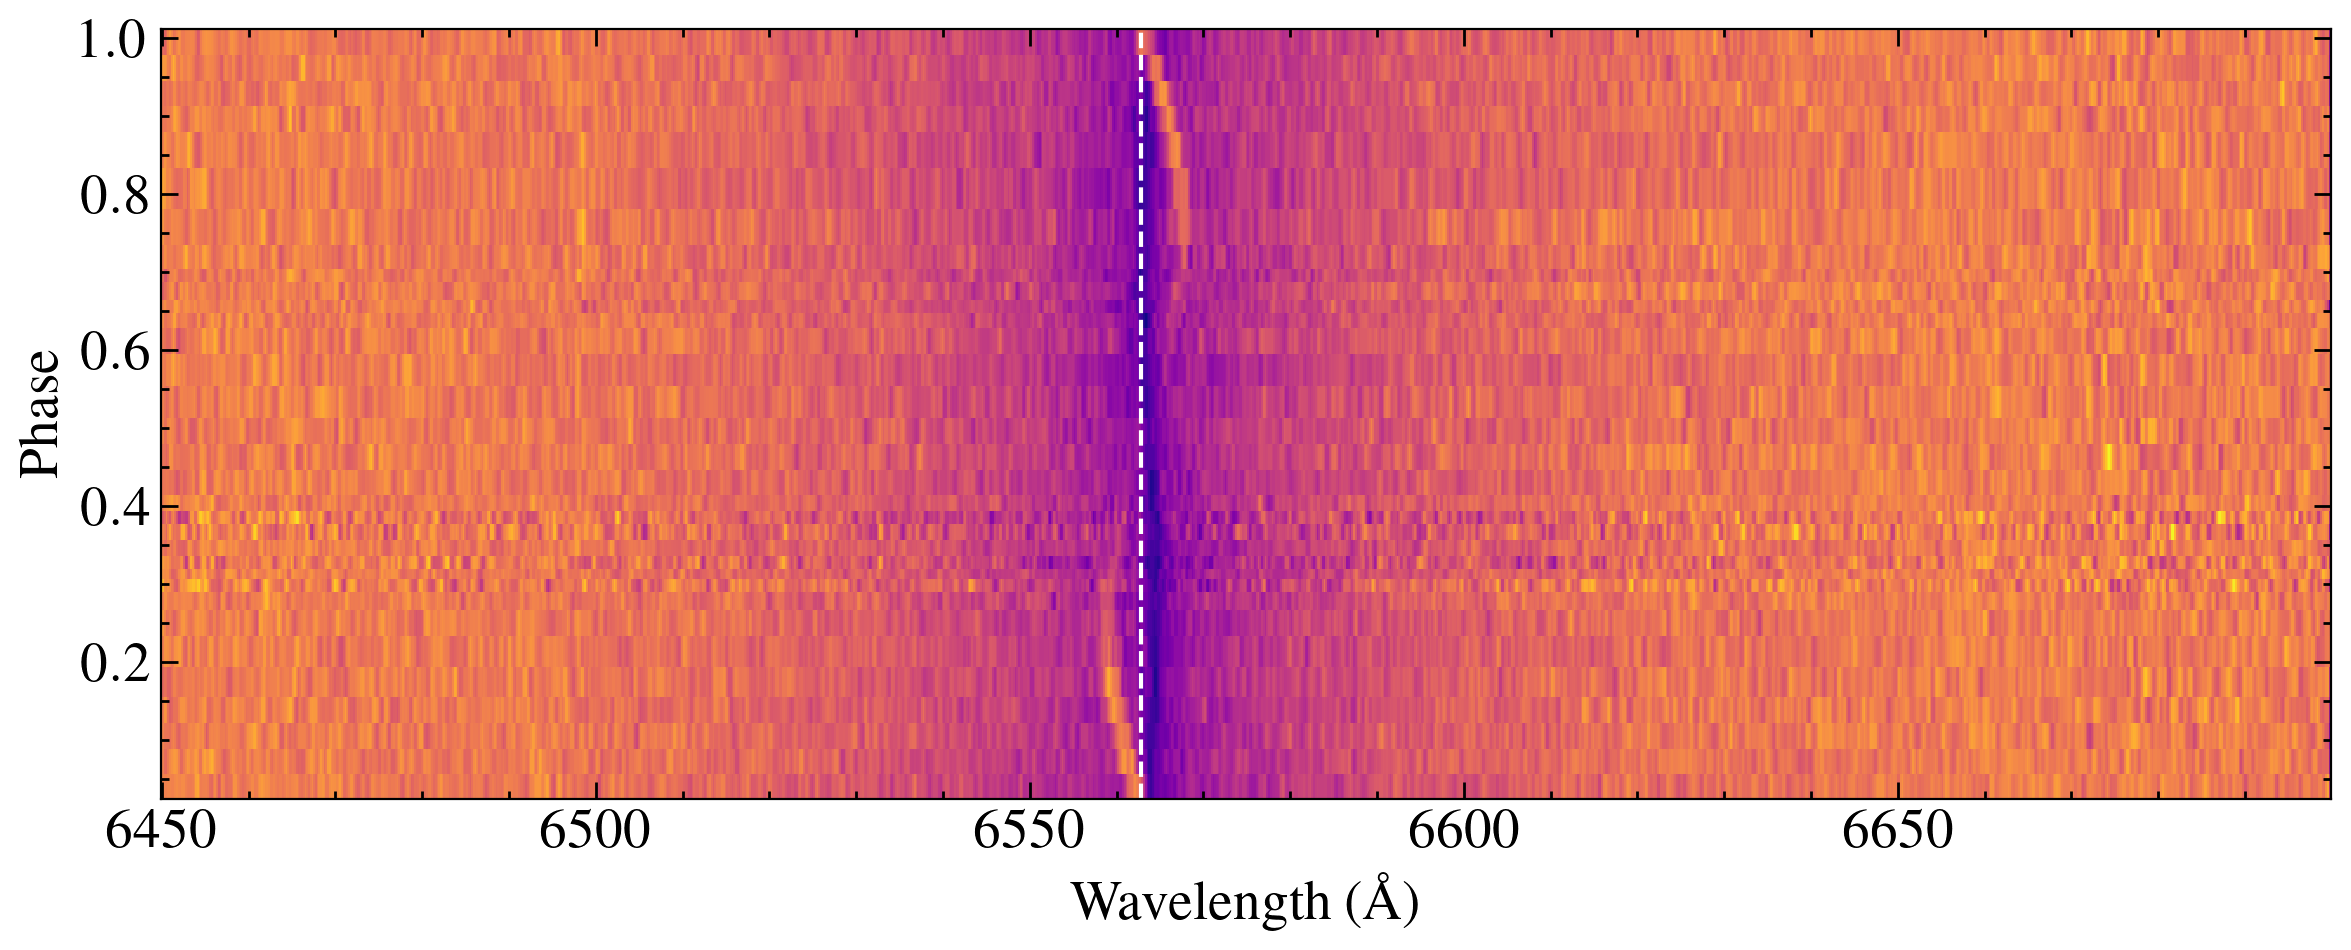

In [21]:
fig, ax = plt.subplots()



ax.pcolor(w_c2, phase_sort,fluxes, cmap='plasma',vmin=0.75)
lines = [8498.02,8542.09,8662.14]
ha = 6562.77
[ax.axvline(line, c='w', ls='--') for line in lines]

ax.set_xlabel(r'Wavelength (\AA)')
ax.set_ylabel(r'Phase')

fig, ax = plt.subplots()



ax.pcolor(w_ha, phase_sort,ha_fluxes, cmap='plasma')

ax.axvline(ha, c='w', ls='--') 

ax.set_xlabel(r'Wavelength (\AA)')
ax.set_ylabel(r'Phase')

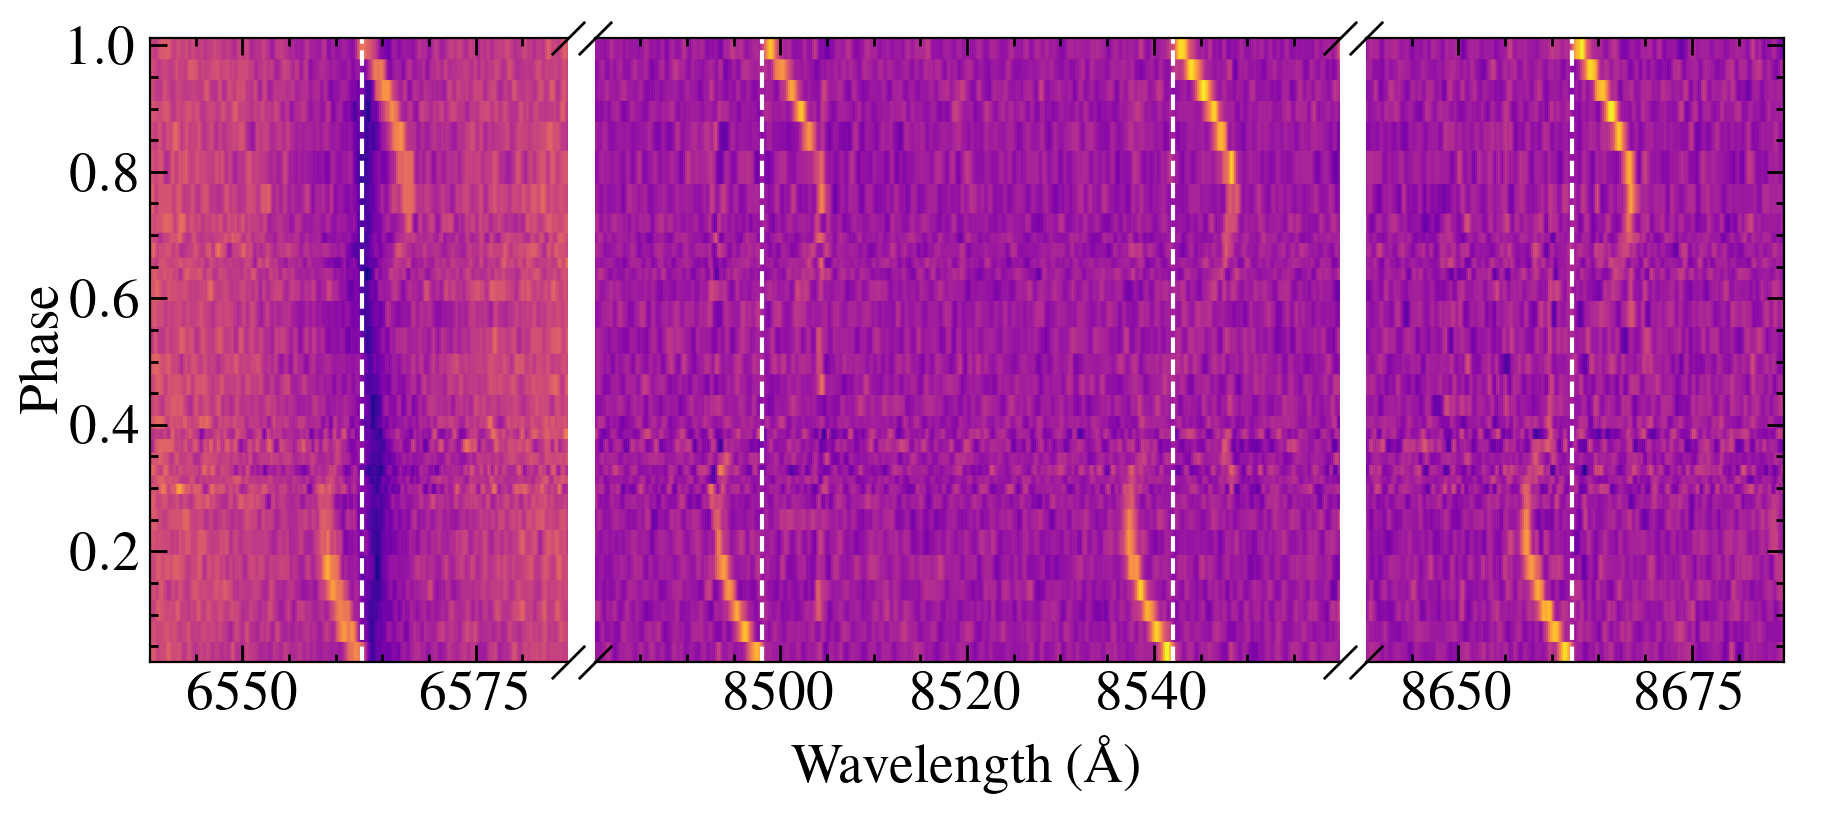

In [22]:

xlims = [[6540.1, 6584.9],[8480.1, 8559.9], [8640.1, 8684.9]]


fig, axes = plt.subplots(ncols=3, sharey = True, figsize=(10, 4), width_ratios=np.diff(xlims)) #making a plot with three subplots that we'll combine


# axes[0].set_ylim(0.0, 0.99)
axes[0].set_xlim(xlims[0]) #setting up the ranges that the plots will cover. One row per subplot
axes[1].set_xlim(xlims[1])
axes[2].set_xlim(xlims[2])

axes[0].pcolor(w_ha, phase_sort,ha_fluxes, cmap='plasma', edgecolor='face')
axes[1].pcolor(w_c2, phase_sort,fluxes, cmap='plasma', edgecolor='face')
axes[2].pcolor(w_c2, phase_sort,fluxes, cmap='plasma', edgecolor='face')

lines = [8498.02,8542.09,8662.14]
ha = 6562.77
[axes[1].axvline(line, c='w', ls='--') for line in lines]
[axes[2].axvline(line, c='w', ls='--') for line in lines]
axes[0].axvline(ha, c='w', ls='--') 



#setting up the slanted lines
d = 1.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

for i in range(len(axes)):
    
    # axes[i].scatter(xs, ys, edgecolor='k') #add the points to each plot
    
    if i > 0: #turn off yticks for everything except the first plot
        axes[i].yaxis.set_tick_params(labelleft=False)
      
    if i != len(axes)-1: #do these things for every subplot exept the last
        axes[i].spines.right.set_visible(False) #turn off right ax
        axes[i].tick_params(right = False, which='both') #turn off right ticks
        axes[i].plot([1, 1], [0, 1], transform=axes[i].transAxes, **kwargs) #add the slanted line to the right corners
   
    if i > 0: #do these things for every subplot except the first
        axes[i].spines.left.set_visible(False) #as for the last loop but for the left
        axes[i].tick_params(left = False, which='both')
        axes[i].plot([0, 0], [1, 0], transform=axes[i].transAxes, **kwargs)
            
#add a frame that goes around all the subplots to add the labels       
bigax = fig.add_subplot(111, frame_on=False)
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
bigax.set_ylabel(r'Phase', labelpad=0) #change labelpad if the label is overlapping the tick labels
bigax.set_xlabel(r'Wavelength (\AA)')
# bigax.set_title('Example plot with split x axis', pad =15) 

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, top=0.95, bottom=0.17) #change the gap in between the subplots

fig.savefig('plots/trailed_spectra.pdf') # use to save the figure.

# plt.show()




In [23]:
np.diff(xlims)

array([[44.8],
       [79.8],
       [44.8]])

In [24]:
min(phases)

np.float64(0.04090007242104132)

In [25]:
phases

array([0.5799983 , 0.4313158 , 0.10645845, 0.07362203, 0.39853003,
       0.69814545, 0.80455374, 0.49689718, 0.71119463, 0.13926527,
       0.29864377, 0.3491218 , 0.25077043, 0.65217503, 0.92933966,
       0.89653153, 0.6455593 , 0.61277288, 0.32492236, 0.21799847,
       0.7585741 , 0.52968689, 0.99492829, 0.67830627, 0.36485663,
       0.39110101, 0.31635973, 0.04090007, 0.86372801, 0.46410287,
       0.96213595, 0.28356738, 0.17207077])